# Dogs vs cats image classification

This notebook is for practising regression with Keras library. This example is taken from Deep Learning with Python by Françoic Chollet (highly recommended).

This notebook contains:

- Visualising image using Keras `ImageDataGenerator`
- Building a CNN from scratch
- Introducing dropout layer and data augmentation for regularisation
- Feature extraction using a pre-trained convnet (VGG16)
- Fine tuning using a pre-trained convnet (VGG16)

In [1]:
import os
import zipfile
import shutil
import pandas as pd
import numpy as np

from pprint import pprint

from keras import layers, models, optimizers, regularizers
from keras.preprocessing.image import (load_img, ImageDataGenerator, array_to_img, 
                                       img_to_array, DirectoryIterator)
from keras.applications import VGG16
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_CHANNELS = 3
BATCH_SIZE = 20

# Space to store experiment results
experiment_results = {}

## Functions

In [3]:
def plot_metric_vs_epochs(data, ax=None, figsize=(16, 5), **set_kwargs):
    """
    data : dict
        A dictionary of data
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    for data_label, data_points in data.items():
        epochs = range(1, len(data_points)+1)
        ax.plot(epochs, data_points, label=data_label)
        ax.legend()
        ax.set(**set_kwargs)

    return fig, ax


def plot_loss_acc(history, figsize=(16, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_metric_vs_epochs(data={k: v for (k, v) in history.history.items() if k in ['loss', 'val_loss']},
                          ax=ax[0],
                          title='Training and validation loss',
                          xlabel='Epochs', 
                          ylabel='Loss')

    plot_metric_vs_epochs(data={k: v for (k, v) in history.history.items() if k in ['acc', 'val_acc']},
                          ax=ax[1],
                          title='Training and validation accuracy',
                          xlabel='Epochs', 
                          ylabel='Accuracy')

    plt.show()
    return fig, ax


def record_results(exp_name, store, model, data):
    if isinstance(data, DirectoryIterator):
        scores = model.evaluate_generator(generator=data,
                                          use_multiprocessing=True)
    else:
        scores = model.evaluate(*data)
    
    res = dict(zip(model.metrics_names, scores))
    store[exp_name] = res
    pprint(store)
    return store


def build_model(**params):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            input_shape=params['input_shape']))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2, 2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(params['rate_dropout_1']))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    
    return model


def extract_features(model, n_samples, data_generator, flatten=False):
    """
    Output predictions of a pre-trained model
    """
    last_layer_shape = list(model.layers[-1].output_shape[1:])
    feature_shape = [n_samples] + last_layer_shape
    
    features = np.zeros(shape=feature_shape)  # Must be equal to the output of the model
    labels = np.zeros(shape=(n_samples))

    # Pass data through convolutional base
    idx_start, idx_end = 0, 0
    for inputs_batch, labels_batch in data_generator:
        features_batch = model.predict(inputs_batch)
        batch_size = features_batch.shape[0]
        idx_end = min(idx_start + batch_size, n_samples)
        
        features[idx_start:idx_end] = features_batch
        labels[idx_start:idx_end] = labels_batch
        
        idx_start += batch_size
        if idx_start >= n_samples:
            break
            
    if isinstance(flatten, tuple):
        features = np.reshape(features, (n_samples, flatten))
    elif flatten:
        features = np.reshape(features, (n_samples, np.prod(last_layer_shape)))
        
    return features, labels


def build_feat_extract_model(base_model=None, **params):
    model = models.Sequential()
    
    if base_model:
        base_model = clone_model(base_model)
        base_model.trainable = False
        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu',
                               kernel_regularizer=regularizers.l1_l2(
                                   l1=params['l1_dense_1'], 
                                   l2=params['l2_dense_1'])))
        
    else:
        model.add(layers.Dense(256, activation='relu', 
                           kernel_regularizer=regularizers.l1_l2(
                               l1=params['l1_dense_1'], 
                               l2=params['l2_dense_1']),
                           input_shape=params['input_shape']))
        
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['rate_dropout_1']))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['acc'])
    
    return model


def clone_model(model):
    tmp_dir = 'tmp/model/'
    os.makedirs(tmp_dir, exist_ok=True)

    tmp_file = os.path.join(tmp_dir, 'clone_model_tmp.h5')
    model.save(tmp_file)
    
    return models.load_model(tmp_file)


def build_fine_tuning_model(base_model, trainable_base_layers, train_generator, validation_generator, **params):
    base_model = clone_model(base_model)

    print('Freeze base network')
    base_model.trainable = False
    print(f'Base model number of trainable params: {len(base_model.trainable_weights)}')

    print('Add custom classifer')
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu',
                           kernel_regularizer=regularizers.l1_l2(
                               l1=params['l1_dense_1'], 
                               l2=params['l2_dense_1'])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['rate_dropout_1']))
    model.add(layers.Dense(1, activation='sigmoid'))

    print('Compile and train custom classifer ')
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['acc'])

    hist_1 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=1.5*image_count['train']//BATCH_SIZE,
            epochs=30,
            validation_data=validation_generator, 
            validation_steps=image_count['validation']//BATCH_SIZE
        )
    
    print('Unfreeze trainable_base_layers')
    model.layers[0].trainable = True
    for layer in model.layers[0].layers:
        layer.trainable = True if layer.name in trainable_base_layers else False
    print(f'Base model number of trainable params: {len(model.layers[0].trainable_weights)}')

    print('Train the whole network')
    # train with a very low learning rate
    model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                  loss='binary_crossentropy',
                  metrics=['acc'])

    hist_2 = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=1.5*image_count['train']//BATCH_SIZE,
        epochs=30,
        validation_data=validation_generator, 
        validation_steps=image_count['validation']//BATCH_SIZE
    )
    
    return model, hist_1, hist_2

## Prepare dataset

### Decompress files

In [4]:
raw_input_path = 'dogs-vs-cats/raw_input/'
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall(raw_input_path)

### Separate into train, validation and test folders

Only consider a reduced number of samples here so that training can be run faster.

In [5]:
base_path = 'dogs-vs-cats'
dataset_dir = {'train': (0, 1000), 
               'validation': (1000, 1500), 
               'test': (1500, 2000)}
category_dir = ['cat', 'dog']
image_count = {}

print('Number of images:')
for dataset_dir_, img_idx in dataset_dir.items():
    for category_dir_ in category_dir:
        current_dir = os.path.join(base_path, dataset_dir_, category_dir_)
        os.makedirs(current_dir, exist_ok=True)
        
        fnames = [f'{category_dir_}.{i}.jpg' for i in range(*img_idx)]
        for fname in fnames:
            src = os.path.join(raw_input_path, 'train', fname)
            dst = os.path.join(current_dir, fname)
            shutil.copyfile(src, dst)
            
        n_images = len(os.listdir(current_dir))
        
        if dataset_dir_ not in image_count:
            image_count[dataset_dir_] = n_images
        else:
            image_count[dataset_dir_] += n_images
            
        print(f'{current_dir}: {n_images}')

Number of images:
dogs-vs-cats/train/cat: 1000
dogs-vs-cats/train/dog: 1000
dogs-vs-cats/validation/cat: 500
dogs-vs-cats/validation/dog: 500
dogs-vs-cats/test/cat: 500
dogs-vs-cats/test/dog: 500


In [6]:
# Create a directory to save model to
model_dir = os.path.join(base_path, 'model')
os.makedirs(model_dir, exist_ok=True)

### Visualise image samples

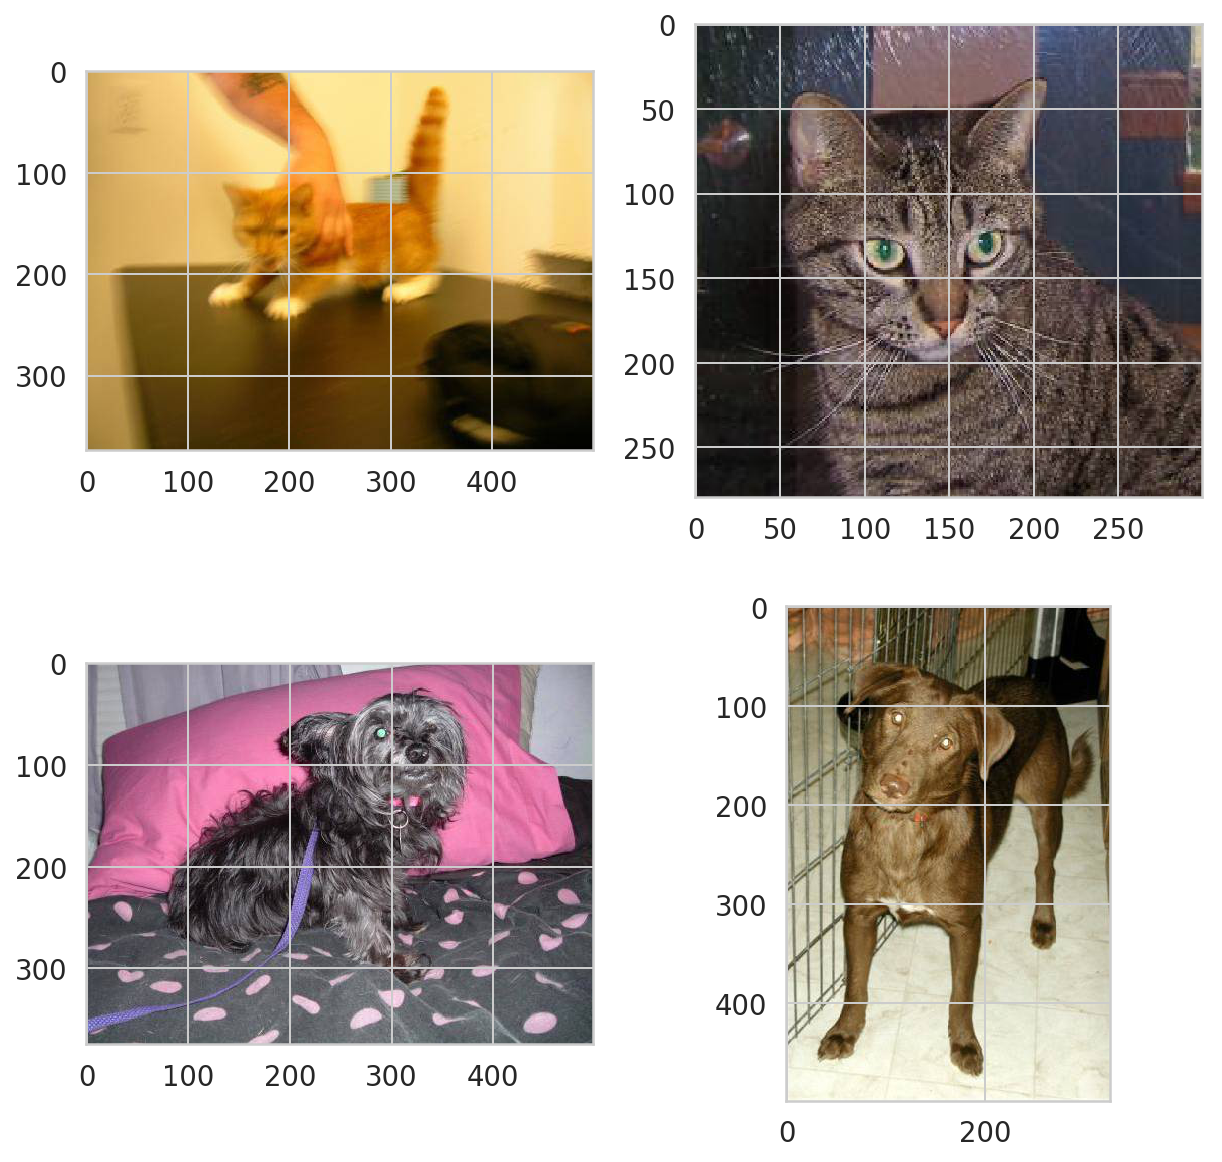

In [7]:
img_samples = ['dogs-vs-cats/train/cat/cat.0.jpg', 'dogs-vs-cats/train/cat/cat.1.jpg',
               'dogs-vs-cats/train/dog/dog.0.jpg', 'dogs-vs-cats/train/dog/dog.1.jpg']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, ax_ in enumerate(ax.flatten()):
    img_sample = load_img(img_samples[i])
    ax_.imshow(img_sample)
plt.show()

### Format images into floating-point tensors

Four steps:
1. Read image files
2. Decode JPEG content to RGB grids of pixels
3. Convert to floating point tensors
4. Rescale pixel values from (0-255) to (0-1) because NN prefers to deal with small numbers

Use `ImageDataGenerator` to carry out the four steps above.

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255.)  # Train data can be augmented (see later)
valid_datagen = ImageDataGenerator(rescale=1/255.)  # Validation data should not be augmented!!!
test_datagen = ImageDataGenerator(rescale=1/255.)  # Test data should not be augmented!!!
train_aug_datagen = ImageDataGenerator(  # ImageDataGenerator has arguments to perform random transformations
    rescale=1/255., 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True)


# It should contain one subdirectory per class.
# Any PNG, JPG, BMP, PPM or TIF images
# inside each of the subdirectories directory tree
# will be included in the generator.
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'train'),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    )

validation_generator = valid_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'validation'),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    )

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'test'),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    )

train_aug_generator = train_aug_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'train'),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Examine what `ImageDataGenerator` does

Each batch has 20 images.  
Each image has (150x150) pixels.  
Each image has 3 colour channels.

In [9]:
for data_batch, labels_batch in train_generator:
    print(f'data batch shape: {data_batch.shape}')
    print(f'label batch shape: {labels_batch.shape}')
    break

data batch shape: (20, 150, 150, 3)
label batch shape: (20,)


### Examine effects of random transformations (data augmentation)

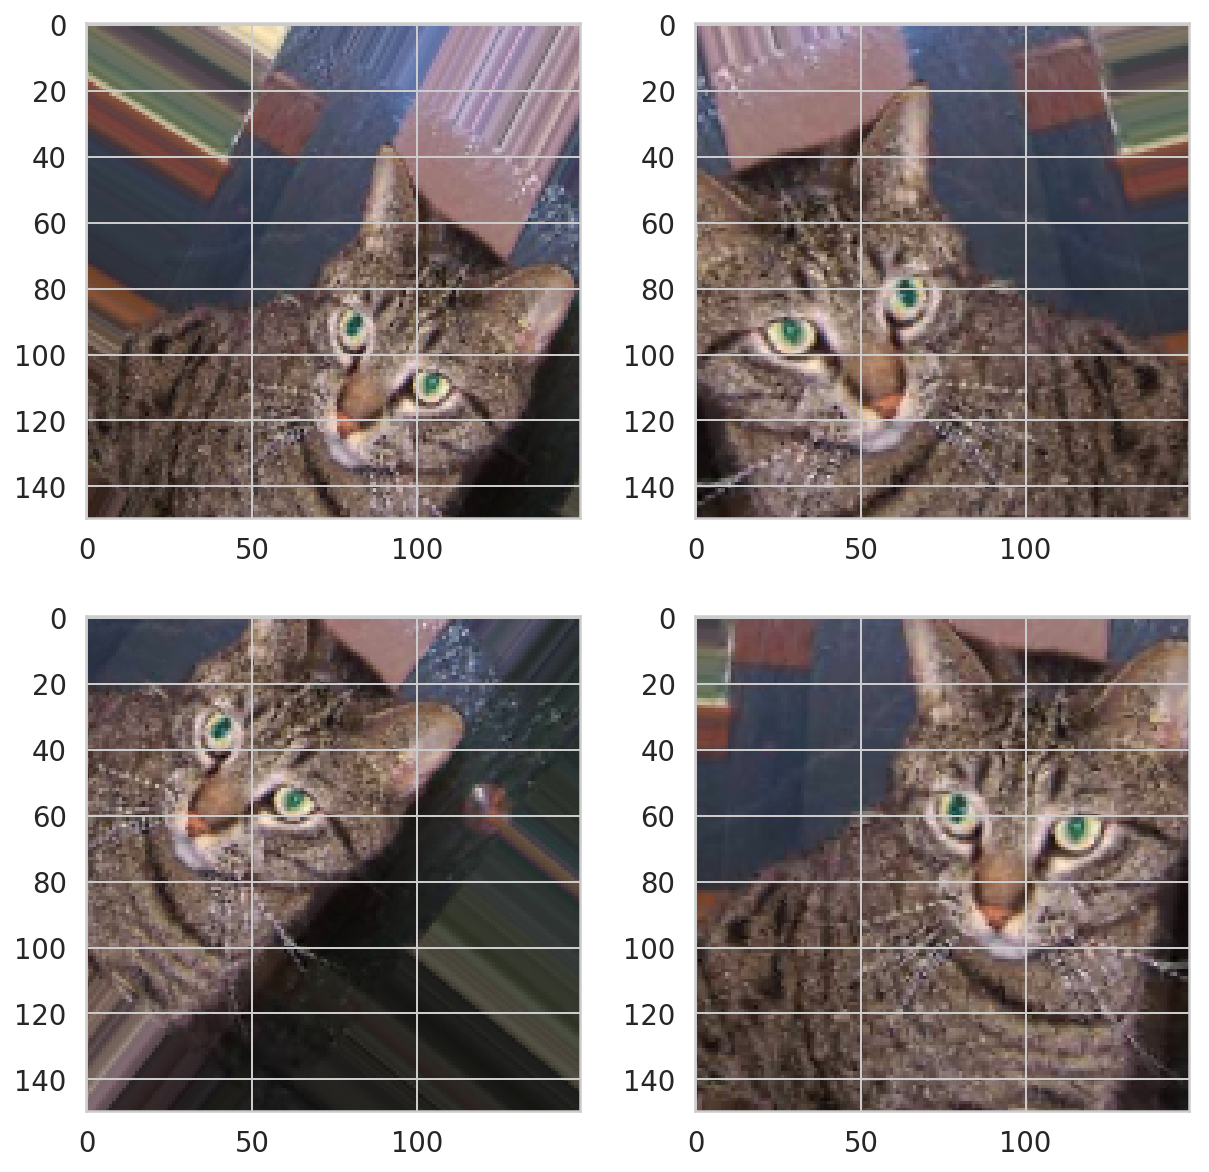

In [10]:
img = load_img('dogs-vs-cats/train/cat/cat.1.jpg', target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax_ = ax.flatten()
for i, batch in enumerate(train_aug_datagen.flow(img, batch_size=1)):
    ax_[i].imshow(array_to_img(batch[0]))
    
    if i == len(ax_) - 1:
        break
        
plt.show()

## Build a small convnet from scratch

No regularisation, data augmentation or pre-trained base model

In [11]:
base_model = build_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                         rate_dropout_1=0.)
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)      

In [23]:
# `fit_generator` is equivalent to `fit` but takes in a generator instead of an array
history_base_model = base_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=image_count['train']//BATCH_SIZE, # at each epoch, number of data batch to be yielded from generator 
                                                      # (in this case 100*20 samples will be yielded)
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=image_count['validation']//BATCH_SIZE # if a generator is specified in `validation_data`, 
                                                           # should specify number of data batch to be yielded 
                                                           # (in this case 50*20 samples will be yielded)
)

base_model.save(os.path.join(model_dir, '01_base_model.h5'))

Epoch 1/30
100/100 [==============================] - 14s 139ms/step - loss: 0.8442 - acc: 0.6380 - val_loss: 1.0233 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.3494 - acc: 0.8490 - val_loss: 3.0787 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 9s 86ms/step - loss: 0.1556 - acc: 0.9480 - val_loss: 2.1604 - val_acc: 0.5000
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.0814 - acc: 0.9755 - val_loss: 1.7110 - val_acc: 0.5170
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.0444 - acc: 0.9900 - val_loss: 0.6277 - val_acc: 0.6200
Epoch 6/30
100/100 [==============================] - 9s 94ms/step - loss: 0.0349 - acc: 0.9930 - val_loss: 0.7565 - val_acc: 0.6710
Epoch 7/30
100/100 [==============================] - 9s 87ms/step - loss: 0.0162 - acc: 0.9960 - val_loss: 1.3420 - val_acc: 0.7050
Epoch 8/30
100/100 [==============================] - 9s 88ms/step 

## Inspect model performance

It is evident from the figures below that the model is overfitting due to 

- A small amount of training data
- No regularisation applied

The overfitting symptoms are:

- Gap between training and validation curves
- Validation loss increases and accuracy stalls after 5 epochs
- Training accuracy and loss tend to 1.0 and 0.0 respectively

In [ ]:
plot_loss_acc(history_base_model)
plt.show()

In [ ]:
experiment_results = record_results(exp_name='base_model',
                                    store=experiment_results,
                                    model=base_model,
                                    data=test_generator)

## Dropout

One way to reduce overfitting is to use a `Dropout` layer after flattening the network.

In [ ]:
dropout_model = build_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                            rate_dropout_1=0.5)

# `fit_generator` is equivalent to `fit` but takes in a generator instead of an array
history_dropout_model = dropout_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=image_count['train']//BATCH_SIZE, # at each epoch, number of data batch to be yielded from generator 
                                                      # (in this case 100*20 samples will be yielded)
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=image_count['validation']//BATCH_SIZE # if a generator is specified in `validation_data`, 
                                                           # should specify number of data batch to be yielded 
                                                           # (in this case 50*20 samples will be yielded)
)

dropout_model.save(os.path.join(model_dir, 'dropout_model.h5'))

In [ ]:
plot_loss_acc(history_dropout_model)
plt.show()

In [ ]:
experiment_results = record_results(exp_name='dropout_model',
                                    store=experiment_results,
                                    model=dropout_model,
                                    data=test_generator)

Comparing the performances on the test sets, with a dropout layer the loss has greatly reduced and accuracy has improved. 

There is more we can do to reduce overfitting!

## Data Augmentation

Another way (specific to computer vision) to tackle overfitting is to artificially generate more images.

Random transformations can be

- Rotation
- Shift
- Shear
- Zoom
- Flip

In [ ]:
aug_model = build_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                        rate_dropout_1=0.)  # model without dropout to see the effects of data augmentation

In [ ]:
history_aug_model = aug_model.fit_generator(
    generator=train_aug_generator,
    steps_per_epoch=1.5*image_count['train']//BATCH_SIZE, # at each epoch, number of data batch to be yielded from generator 
                                                          # (in this case 100*32 samples will be yielded)
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=image_count['validation']//BATCH_SIZE # if a generator is specified in `validation_data`, 
                                                           # should specify number of data batch to be yielded 
                                                           # (in this case 50*32 samples will be yielded)
)

aug_model.save(os.path.join(model_dir, 'aug_model.h5'))

In [ ]:
plot_metric_vs_epochs(history_aug_model)
plt.show()

We can see from the figures above that the training curves are closely tracking the validation curves - overfitting has been reduced.

In [ ]:
experiment_results = record_results(exp_name='aug_model',
                                    store=experiment_results,
                                    model=aug_model,
                                    data=test_generator)

We can see the performance is getting better! 

TODO: having a dropout layer together with data augementation

## Feature extraction using a pre-trained convnet

### Method 1: The features of each image in the dataset are extracted by calling the predict method of the conv_base model.


In [ ]:
vgg16_model = VGG16(weights='imagenet',
                    include_top=False,  # False means removing the classifier at the top
                    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

vgg16_model.summary()

Extract features from VGG16 convolutional base and store in memory.

In [ ]:
train_features, train_labels = extract_features(model=vgg16_model, 
                                                n_samples=2000, 
                                                data_generator=train_generator,  
                                                flatten=True) 

train_aug_features, train_aug_labels = extract_features(model=vgg16_model, 
                                                        n_samples=6000, 
                                                        data_generator=train_aug_generator,
                                                        flatten=True)

validation_features, validation_labels = extract_features(model=vgg16_model, 
                                                          n_samples=1000, 
                                                          data_generator=validation_generator,
                                                          flatten=True) 

test_features, test_labels = extract_features(model=vgg16_model, 
                                              n_samples=1000, 
                                              data_generator=test_generator,
                                              flatten=True) 

In [ ]:
feat_extract_1_model = build_feat_extract_model(input_shape=(np.prod(vgg16_model.layers[-1].output_shape[1:]),),
                                                l1_dense_1=0.,
                                                l2_dense_1=0.,
                                                rate_dropout_1=0.)

history_feat_extract_1_model = feat_extract_1_model.fit(x=train_features,
                                                        y=train_labels,
                                                        epochs=30,
                                                        batch_size=50,
                                                        validation_data=(validation_features, validation_labels),
                                                        verbose=1)

feat_extract_1_model.save(os.path.join(model_dir, 'feat_extract_1_model.h5'))

In [ ]:
plot_loss_acc(history_feat_extract_1_model)
plt.show()

In [ ]:
experiment_results = record_results(exp_name='feat_extract_1_model',
                                    store=experiment_results,
                                    model=feat_extract_1_model,
                                    data=(test_features, test_labels))

The performance has improved a lot purely from extracting features from the VGG16 pre-trained model. However it looks like overfitting started to occur almost from the start. 

Let's add some regularisation in the model...

In [ ]:
feat_extract_1_reg_model = build_feat_extract_model(input_shape=(np.prod(vgg16_model.layers[-1].output_shape[1:]),),
                                                    l1_dense_1=0.001,
                                                    l2_dense_1=0.001,
                                                    rate_dropout_1=0.3)

history_feat_extract_1_reg_model = feat_extract_1_reg_model.fit(
    x=train_aug_features,
    y=train_aug_labels,
    epochs=30,
    batch_size=50,
    validation_data=(validation_features, validation_labels),
    verbose=1)

feat_extract_1_reg_model.save(os.path.join(model_dir, 'feat_extract_1_reg_model.h5'))

In [ ]:
plot_loss_acc(history_feat_extract_1_reg_model)
plt.show()

In [ ]:
experiment_results = record_results(exp_name='feat_extract_1_reg_model',
                                    store=experiment_results,
                                    model=feat_extract_1_reg_model,
                                    data=(test_features, test_labels))

We can see from the figures above that with regularisation methods we are able to reduce overfitting (in fact validation performances are better than training performances). However it is somehow strange that the performance on the test set has dropped (?).

### Method 2: The convolutional base is extended by adding a densely connected classifier on top of it and the training is done end-to-end. However, (part of) the convolutional layers are frozen to prevent their weights from being updated.


In [ ]:
feat_extract_2_model = build_feat_extract_model(vgg16_model,
                                                base_trainable=False,
                                                l1_dense_1=0.001,
                                                l2_dense_1=0.001,
                                                rate_dropout_1=0.3)

history_feat_extract_2_model = feat_extract_2_model.fit_generator(
    generator=train_aug_generator,
    steps_per_epoch=1.5*image_count['train']//BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=image_count['validation']//BATCH_SIZE
)

feat_extract_2_model.save(os.path.join(model_dir, 'feat_extract_2_model.h5'))

In [ ]:
plot_loss_acc(history_feat_extract_2_model)
plt.show()

In [ ]:
experiment_results = record_results(exp_name='feat_extract_2_model',
                                    store=experiment_results,
                                    model=feat_extract_2_model,
                                    data=test_generator)

## Fine tuning using a pre-trained convnet

In [ ]:
vgg16_model = VGG16(weights='imagenet',
                    include_top=False,  # False means removing the classifier at the top
                    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

In [ ]:
fine_tune_model, hist_fine_tune_model_1, hist_fine_tune_model_2 = \
    build_fine_tuning_model(base_model=vgg16_model,
                            trainable_base_layers = ['block5_conv1', 'block5_conv2', 'block5_conv3'],
                            train_generator=train_aug_generator, 
                            validation_generator=validation_generator,
                            l1_dense_1=0.001,
                            l2_dense_1=0.001,
                            rate_dropout_1=0.3)

In [ ]:
plot_loss_acc(hist_fine_tune_model_1)
plot_loss_acc(hist_fine_tune_model_2)
plt.show()

In [ ]:
experiment_results = record_results(exp_name='fine_tune_model',
                                    store=experiment_results,
                                    model=fine_tune_model,
                                    data=test_generator)

We can see a better performance achieved by using fine tuning, at the expense of more computational power.

TODO: classification report